# Testing
### Gemeinderatswahlen 2018: Resultate aller Kandidierenden und Herkunft der Stimmen
Detaillierte Resultate der erhaltenen Stimmen aller 1054 Kandidierenden für die Gemeinderatswahlen 2018 nach Vor- und Nachname, Wahlkreis, Liste, Total Stimmen, parteieigener Stimmen, parteieigenen Stimmen aus unveränderten Wahllisten, parteifremden Stimmen, Stimmen aus veränderten Wahllisten, etc.

Datum: 08.02.2022

### Importiere die notwendigen Packages

In [36]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [37]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [38]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [39]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [40]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=14, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=45, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [41]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [42]:
package_name = "politik_gemeinderatswahlen_2018_resultate"

In [43]:
dataset_name = "GRW_2018_Resultate_und_herkunft_der_stimmen.csv"


**Statische Pfade in DWH-Dropzones**

In [44]:
## gibt's hier nicht. direkter upload
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [45]:
## gibt's hier nicht. direkter upload
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [46]:
## gibt's hier nicht. direkter upload. die url wird aber ab dhw-dropzone auch geharvested
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"

In [47]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [48]:
from IPython.display import Markdown as md

In [49]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2018_resultate 

In [50]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2018_resultate 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [51]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [52]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2018_resultate/download/GRW_2018_Resultate_und_herkunft_der_stimmen.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [53]:
# Read the data
imp_data2betested = pd.read_csv(
    fp
    , sep=','
    #,parse_dates=['Abstimmungs_Datum','Aktualisierungs_Datum'] #'Abstimmungs_Datum',
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')
imp_data2betested.dtypes

done


Liste_ID                    int64
Liste_Cd                   object
Liste_Bez_kurz             object
Liste_Bez_lang             object
Wahlkreis                  object
Wahlkreis_Sort              int64
Nachname                   object
Vorname                    object
Wahlresultat               object
total_stim                  int64
part_eig_stim               int64
part_eig_stim_unv_wl        int64
part_frmd_stim              int64
stim_verae_wl_SP            int64
stim_verae_wl_SVP           int64
stim_verae_wl_FDP           int64
stim_verae_wl_Gruene        int64
stim_verae_wl_glp           int64
stim_verae_wl_AL            int64
stim_verae_wl_CVP           int64
stim_verae_wl_DU           object
stim_verae_wl_EDU           int64
stim_verae_wl_vernunft    float64
stim_verae_wl_PdA          object
stim_verae_wl_evp_bdp       int64
ant_frmd_stim             float64
dtype: object

Berechne weitere Attribute

In [54]:
data2betested = (
    imp_data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        #Abstimmungs_Datum_str = lambda x: x.Abstimmungs_Datum.astype(str),
    )
    .sort_values('total_stim', ascending=False)
    )
data2betested.dtypes




Liste_ID                    int64
Liste_Cd                   object
Liste_Bez_kurz             object
Liste_Bez_lang             object
Wahlkreis                  object
Wahlkreis_Sort              int64
Nachname                   object
Vorname                    object
Wahlresultat               object
total_stim                  int64
part_eig_stim               int64
part_eig_stim_unv_wl        int64
part_frmd_stim              int64
stim_verae_wl_SP            int64
stim_verae_wl_SVP           int64
stim_verae_wl_FDP           int64
stim_verae_wl_Gruene        int64
stim_verae_wl_glp           int64
stim_verae_wl_AL            int64
stim_verae_wl_CVP           int64
stim_verae_wl_DU           object
stim_verae_wl_EDU           int64
stim_verae_wl_vernunft    float64
stim_verae_wl_PdA          object
stim_verae_wl_evp_bdp       int64
ant_frmd_stim             float64
dtype: object

In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [55]:
data2betested.head(3)

,Liste_ID,Liste_Cd,Liste_Bez_kurz,Liste_Bez_lang,Wahlkreis,Wahlkreis_Sort,Nachname,...,stim_verae_wl_CVP,stim_verae_wl_DU,stim_verae_wl_EDU,stim_verae_wl_vernunft,stim_verae_wl_PdA,stim_verae_wl_evp_bdp,ant_frmd_stim
426,1,SP,Liste 1,SP - Sozialdemokratische Partei,7 + 8,5,Manser,...,22,.,9,NaN,.,14,11.6
101,1,SP,Liste 1,SP - Sozialdemokratische Partei,3,2,Wiesmann,...,7,.,0,NaN,4,3,9.2
427,1,SP,Liste 1,SP - Sozialdemokratische Partei,7 + 8,5,Glaser,...,16,.,4,NaN,.,9,9.7


In [56]:
#data2betested.dtypes

test

In [57]:
data2betested.shape

(1054, 26)

Beschreibe einzelne Attribute

In [58]:
data2betested.describe()

,Liste_ID,Wahlkreis_Sort,total_stim,part_eig_stim,part_eig_stim_unv_wl,part_frmd_stim,stim_verae_wl_SP,...,stim_verae_wl_glp,stim_verae_wl_AL,stim_verae_wl_CVP,stim_verae_wl_EDU,stim_verae_wl_vernunft,stim_verae_wl_evp_bdp,ant_frmd_stim
count,1054.0,1054.0,1054.0,1054.0,1054.0,1054.0,1054.0,...,1054.0,1054.0,1054.0,1054.0,138.0,1054.0,1054.0
mean,5.3,5.1,1368.2,1275.7,912.4,92.6,168.7,...,48.2,33.2,14.8,1.7,2.0,12.2,7.9
std,3.4,2.5,1178.4,1128.1,772.0,148.0,383.2,...,106.2,80.5,43.0,5.9,2.1,33.8,9.0
min,1.0,1.0,53.0,46.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.0,3.0,510.0,475.0,349.0,18.0,4.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.2
50%,5.0,5.0,1131.5,1043.0,761.0,42.5,14.0,...,7.0,2.0,1.0,0.0,1.0,1.0,4.7
75%,7.0,8.0,1694.8,1561.2,1124.0,94.0,64.8,...,26.0,17.0,5.0,1.0,3.0,5.0,9.8
max,12.0,9.0,5337.0,4842.0,2917.0,1360.0,2007.0,...,717.0,607.0,469.0,92.0,9.0,287.0,64.6


Wie viele Nullwerte gibt es im Datensatz?

In [59]:
data2betested.isnull().sum()

Liste_ID                    0
Liste_Cd                    0
Liste_Bez_kurz              0
Liste_Bez_lang              0
Wahlkreis                   0
Wahlkreis_Sort              0
Nachname                    0
Vorname                     0
Wahlresultat                0
total_stim                  0
part_eig_stim               0
part_eig_stim_unv_wl        0
part_frmd_stim              0
stim_verae_wl_SP            0
stim_verae_wl_SVP           0
stim_verae_wl_FDP           0
stim_verae_wl_Gruene        0
stim_verae_wl_glp           0
stim_verae_wl_AL            0
stim_verae_wl_CVP           0
stim_verae_wl_DU            0
stim_verae_wl_EDU           0
stim_verae_wl_vernunft    916
stim_verae_wl_PdA           0
stim_verae_wl_evp_bdp       0
ant_frmd_stim               0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [60]:
#data2betested = data2betested.set_index("Aktualisierungs_Datum")

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [61]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [62]:
#data2betested.dtypes

### Visualisierungen

In [63]:
data2betested.columns

Index(['Liste_ID', 'Liste_Cd', 'Liste_Bez_kurz', 'Liste_Bez_lang', 'Wahlkreis', 'Wahlkreis_Sort',
       'Nachname', 'Vorname', 'Wahlresultat', 'total_stim', 'part_eig_stim',
       'part_eig_stim_unv_wl', 'part_frmd_stim', 'stim_verae_wl_SP', 'stim_verae_wl_SVP',
       'stim_verae_wl_FDP', 'stim_verae_wl_Gruene', 'stim_verae_wl_glp', 'stim_verae_wl_AL',
       'stim_verae_wl_CVP', 'stim_verae_wl_DU', 'stim_verae_wl_EDU', 'stim_verae_wl_vernunft',
       'stim_verae_wl_PdA', 'stim_verae_wl_evp_bdp', 'ant_frmd_stim'],
      dtype='object')

#### Barcharts mit Seaborn

In [64]:
#help(sns.catplot)     

In [65]:
#Stile for the following sns graphs
sns.set_theme(style="darkgrid", color_codes=True) #style must be one of white, dark, whitegrid, darkgrid, ticks


# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')

In [66]:
#data2betested.head()

In [67]:
myAgg = data2betested.query('Liste_Cd !=""') \
    .groupby(['Liste_ID','Liste_Cd', 'Liste_Bez_lang', 'Wahlresultat']) \
    .agg(sum_total_stim=('total_stim', 'sum'), sum_part_eig_stim=('part_eig_stim', 'sum')) \
    .sort_values('Liste_ID', ascending=True) 

#myAgg.reset_index()

Text(0.5, 0.98, 'Anzahl aller Stimmen nach Partei und Wahlresultat 2018')

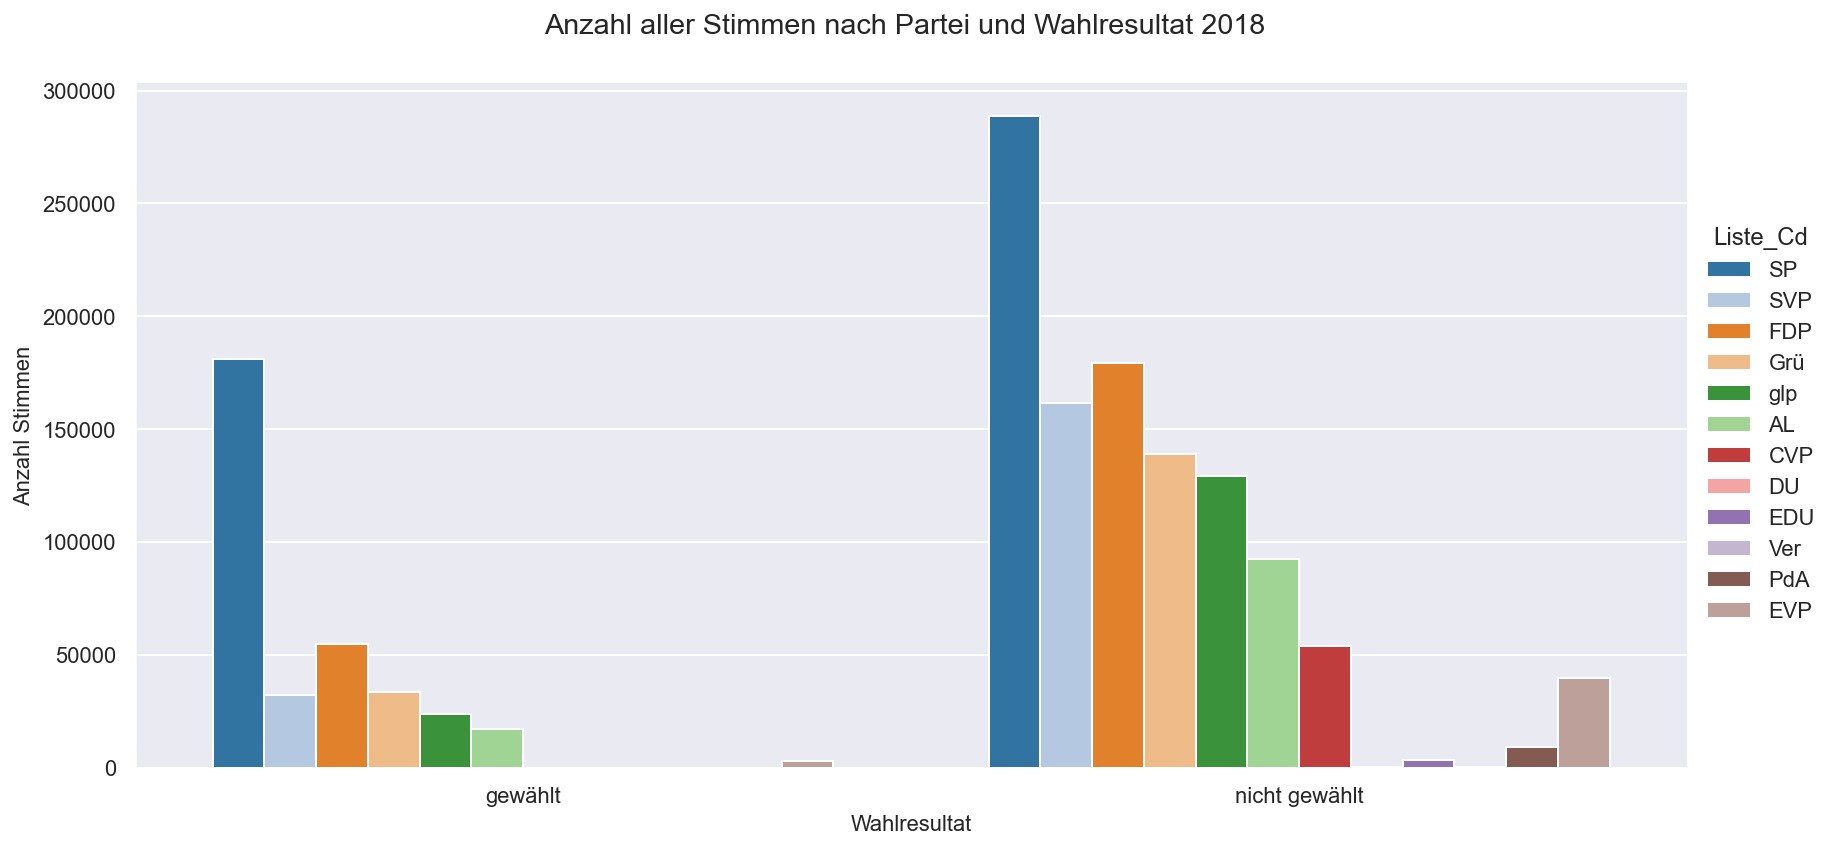

In [68]:
myTitle="Anzahl aller Stimmen nach Partei und Wahlresultat 2018"

#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Wahlresultat"
            , y="sum_total_stim"
            , hue="Liste_Cd"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="tab20" #'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
            , height=6
            , aspect=2
            , edgecolor= None
            , order=None, legend_out=True
            ,data=myAgg.reset_index()
           )
myHist.set_xticklabels(rotation=0)
myHist.set_xlabels('Wahlresultat', fontsize=11) # not set_label
myHist.set_ylabels('Anzahl Stimmen', fontsize=11)

myHist.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
myHist.fig.suptitle(myTitle)

In [69]:
#data2betested.dtypes
myAgg = data2betested.query('Wahlresultat =="gewählt"') \
    .groupby(['Liste_ID','Liste_Cd', 'Liste_Bez_lang', 'Wahlresultat','Wahlkreis_Sort','Wahlkreis']) \
    .agg(sum_total_stim=('total_stim', 'sum'), sum_part_eig_stim=('part_eig_stim', 'sum')) \
    .sort_values('Liste_ID', ascending=True) 

myAgg.reset_index().head(2)

,Liste_ID,Liste_Cd,Liste_Bez_lang,Wahlresultat,Wahlkreis_Sort,Wahlkreis,sum_total_stim,sum_part_eig_stim
0,1,SP,SP - Sozialdemokratische Partei,gewählt,1,1 + 2,14040,12869
1,1,SP,SP - Sozialdemokratische Partei,gewählt,2,3,29715,27844


Text(0.5, 0.98, 'Anzahl Stimmen von gewählten nach Wahkreis und Partei, 2018')

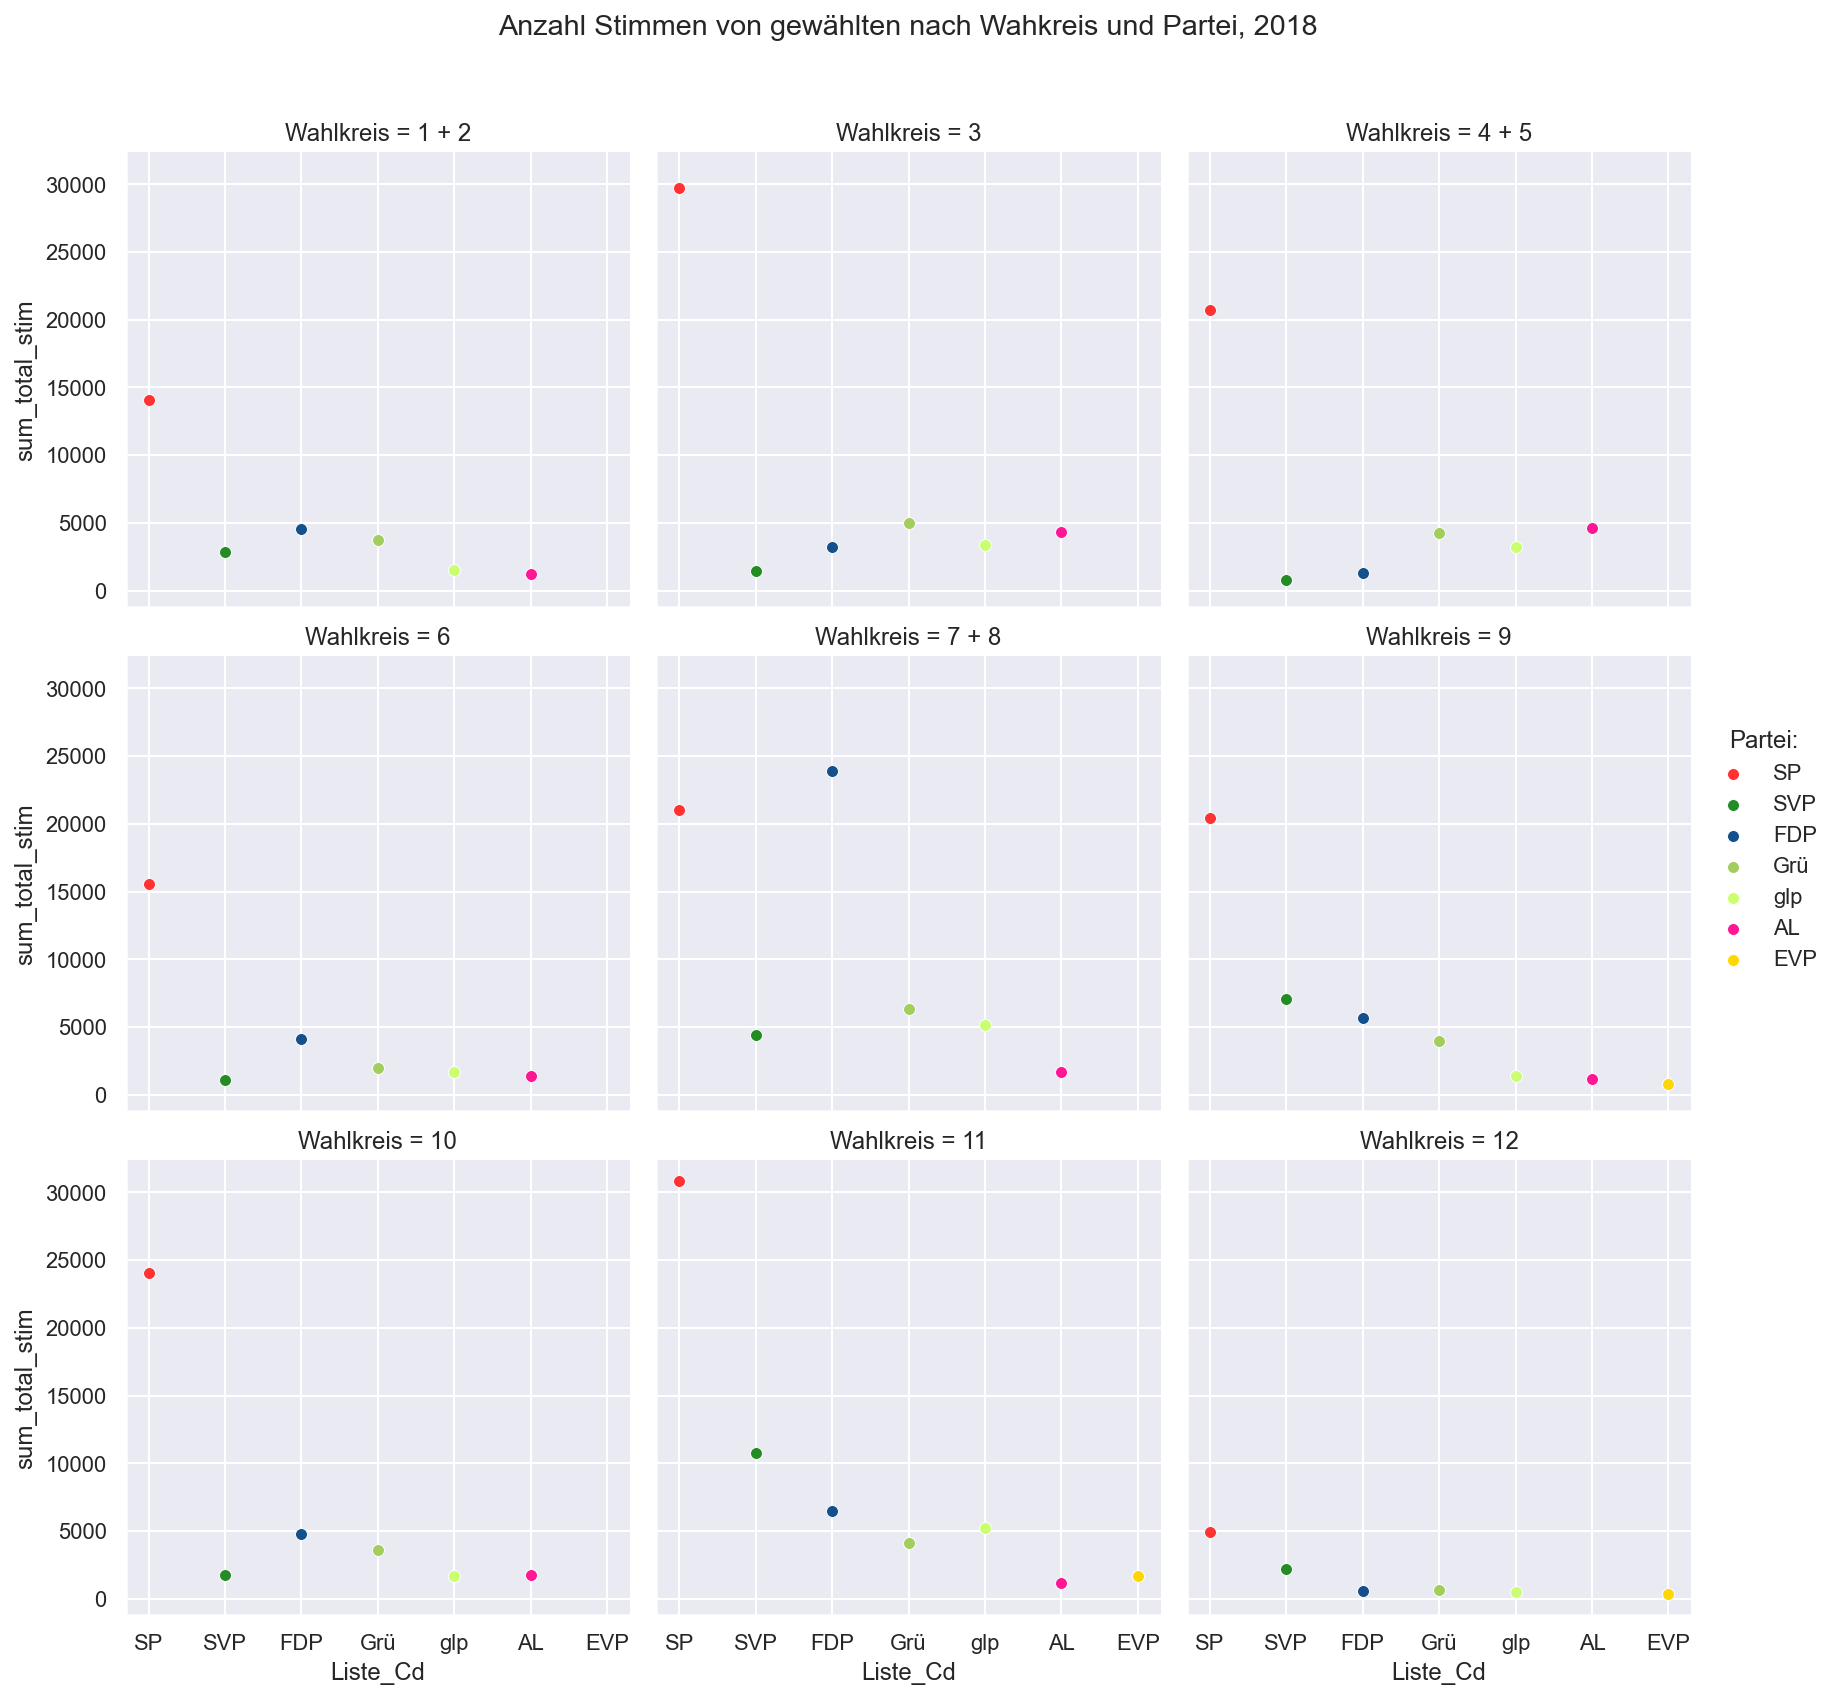

In [70]:
myTitle="Anzahl Stimmen von gewählten nach Wahkreis und Partei, 2018"
myPalette ={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grü':'#A2CD5A','glp':'#CAFF70','CVP':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }

g = sns.FacetGrid(myAgg.reset_index(), col="Wahlkreis", hue="Liste_Cd", col_wrap=3, height=4, aspect=1, palette=myPalette)
g.map(sns.scatterplot, "Liste_Cd", "sum_total_stim", alpha=.99)
#g.map(sns.lineplot, "Liste_Cd","sum_total_stim", alpha=.99)

g.add_legend(title="Partei:")
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle(myTitle)



## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Anzahl Wohnungen in BAUPROJEKTEN nach Projektstatus, Kreis und Quartier 2021

In [106]:
data2betested.dtypes

Total          int64
Partei        object
ParteiSort     int64
Anzahl         int64
dtype: object

In [ ]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum'))\
    .sort_values('sum_ProjAnzWhg', ascending=False) 

myTreemapAgg.reset_index().head(3)

In [ ]:
fig = px.treemap(myTreemapAgg.query('sum_ProjAnzWhg >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjAnzWhg'
                 , color='sum_ProjAnzWhg'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Anzahl Wohnungen nach Projektstatus, Kreis und Quartier

In [33]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
dtype: object

In [34]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjKosten=('ProjKosten', 'sum'), sum_Whg_1_3_Zi=('Whg_1_3_Zi', 'sum'),sum_Whg_4plus_Zi=('Whg_4plus_Zi', 'sum'))\
    .sort_values('sum_Whg_1_3_Zi', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjKosten,sum_Whg_1_3_Zi,sum_Whg_4plus_Zi
0,2021-01-01,Seebach,Kreis 11,Im Bau,867143,1098,561
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,320688,611,185
2,2021-01-01,Altstetten,Kreis 9,Im Bau,593275,601,181


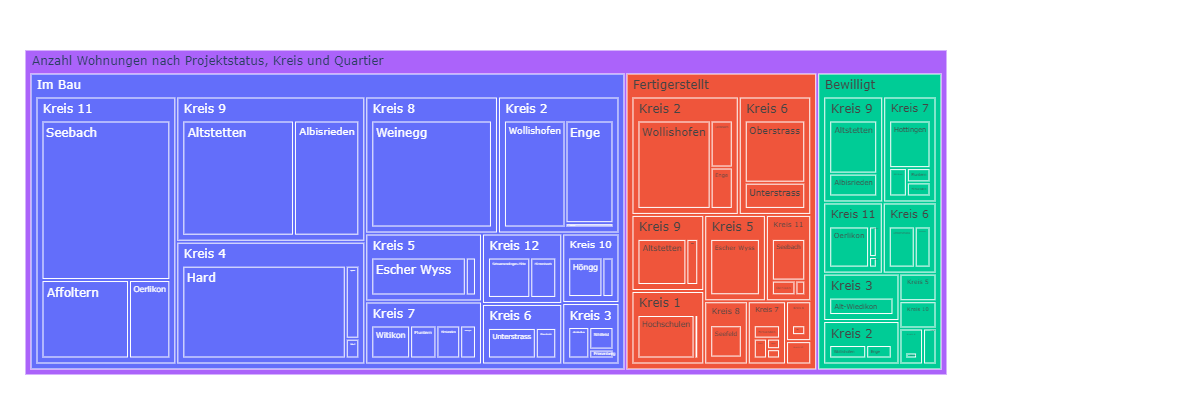

In [35]:
fig = px.treemap(myTreemapAgg.query('sum_ProjKosten >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjKosten'
                 , color='ProjStatus'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [36]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [48]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [49]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [50]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [67]:
m = leafmap.Map()


#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

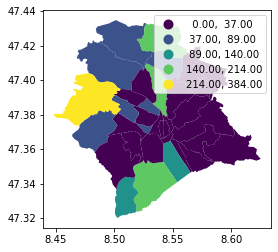

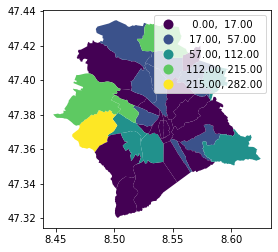

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

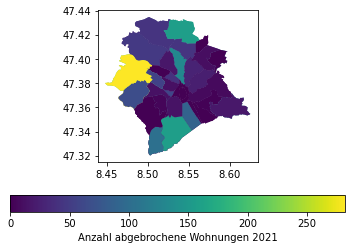

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**